# Подготовка данных в таблице rides

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Загрузка данных

In [2]:
path  = 'data/rides.csv'
df_rides = pd.read_csv(path, sep=',', decimal='.', encoding='utf-8')
df_rides.head()


,Id,Start Date,End Date,Start Location,Start District,End Location,End District,Distance,Promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0


## Обработка заголовков

In [3]:
df_rides.columns = df_rides.columns.str.lower().str.replace(' ', '_')

print(df_rides.columns)


Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo'],
      dtype='object')


## Удаление дубликатов

In [4]:
df_rides.drop_duplicates(inplace=True)
print(f'Размер датасета после удаления дубликатов: {df_rides.shape}')


Размер датасета после удаления дубликатов: (97372, 9)


## Конвертация времени

In [5]:
# Приведение столбцов времени к формату datetime
df_rides['start_date'] = pd.to_datetime(df_rides['start_date'])
df_rides['end_date'] = pd.to_datetime(df_rides['end_date'])

df_rides.dtypes[['start_date', 'end_date']]


start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

## Функции нормализации текста

In [6]:
def normalize_district(district):
    """Нормализация названий районов: заглавная буква, обработка дефисов."""
    district = district[0].upper() + district[1:].replace(' ', '-', 1)
    if '-' in district:
        words = district.split('-')
        words[1] = words[1][0].upper() + words[1][1:]
        district = '-'.join(words)
    return district

def normalize_location(location):
    """Нормализация локаций: удаление 'ул', лишних символов, приведение регистра."""
    location = location.lower()
    location = location.replace('ул', '', 1).lstrip('. ')
    location = location[0].upper() + location[1:]
    if ' ' in location:
        words = location.split()
        words[1] = words[1][0].upper() + words[1][1:]
        location = ' '.join(words)
    return location


## Применение нормализации

In [7]:
# Применение функций к текстовым столбцам
df_rides['start_district'] = df_rides['start_district'].apply(normalize_district)
df_rides['end_district'] = df_rides['end_district'].apply(normalize_district)

df_rides['start_location'] = df_rides['start_location'].apply(normalize_location)
df_rides['end_location'] = df_rides['end_location'].apply(normalize_location)

# Проверка случайной выборки
df_rides[['start_district', 'start_location']].sample(5)


,start_district,start_location
26898,Ленинский,Кирова
17484,Заречный,Садовая
98079,Центральный,Крупской
71204,Северо-Западный,Первомайская
27252,Ленинский,Подгорная


## Расчет длительности и фильтрация временных аномалий

In [8]:
# 1. Расчет длительности поездки в секундах
df_rides['duration'] = (df_rides['end_date'] - df_rides['start_date']).dt.total_seconds()

# 2. Определение масок для аномалий
mask_negative_duration = df_rides['end_date'] < df_rides['start_date']
mask_too_short = df_rides['duration'] < 60       # Менее 1 минуты
mask_too_long = df_rides['duration'] > 7 * 3600  # Более 7 часов

# 3. Фильтрация
print(f"Удалено записей с аномальным временем: {(mask_negative_duration | mask_too_short | mask_too_long).sum()}")
df_rides = df_rides[~(mask_negative_duration | mask_too_short | mask_too_long)].copy()

# 4. КОНСТАНТЫ (выбраны исходя из графиков)
MIN_DISTANCE = 10 # 10 метров
MAX_DISTANCE = 60000 # 60 км

Удалено записей с аномальным временем: 0


## Фильтрация аномалий дистанции по нижней границе

количество поездок с расстоянием < 10м:  2939


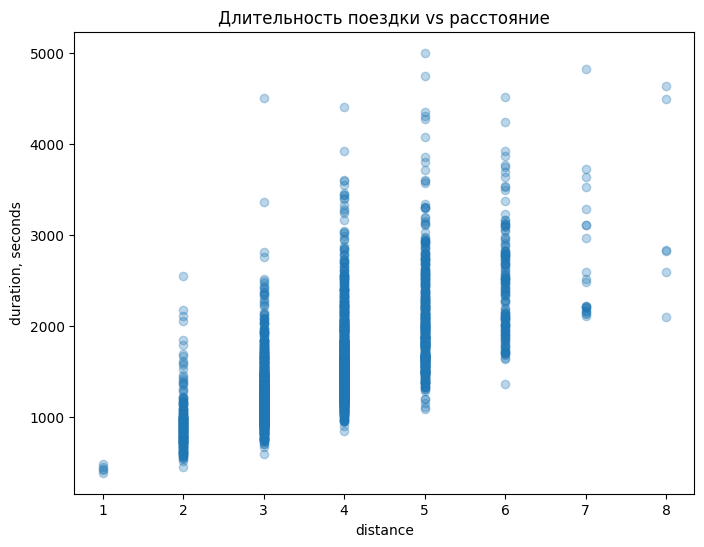

In [9]:
rides_trim_min = df_rides[df_rides['distance'] <= MIN_DISTANCE]

print('количество поездок с расстоянием < 10м: ', rides_trim_min['distance'].count())

plt.figure(figsize=(8, 6))
plt.scatter(rides_trim_min['distance'], rides_trim_min['duration'], alpha=0.3)
plt.xlabel('distance')
plt.ylabel('duration, seconds')
plt.title('Длительность поездки vs расстояние')
plt.show()

## Фильтрация нормальных поездок

количество поездок с расстоянием от 10м до 20000м:  92659


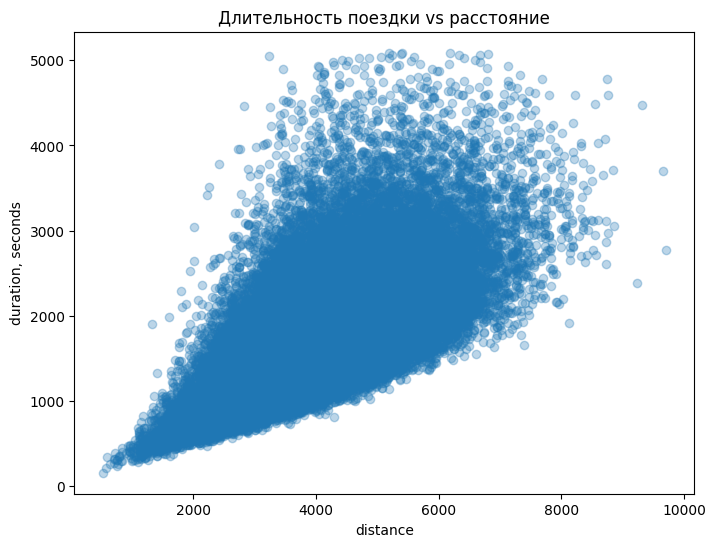

In [10]:
rides_trim = df_rides[(df_rides['distance'] <= MAX_DISTANCE) & (df_rides['distance'] > MIN_DISTANCE)]

print('количество поездок с расстоянием от 10м до 20000м: ', rides_trim['distance'].count())

plt.figure(figsize=(8, 6))
plt.scatter(rides_trim['distance'], rides_trim['duration'], alpha=0.3)
plt.xlabel('distance')
plt.ylabel('duration, seconds')
plt.title('Длительность поездки vs расстояние')
plt.show()

## Фильтрация аномалий дистанции по верхней границе

количество поездок с расстоянием > 60000м: 593


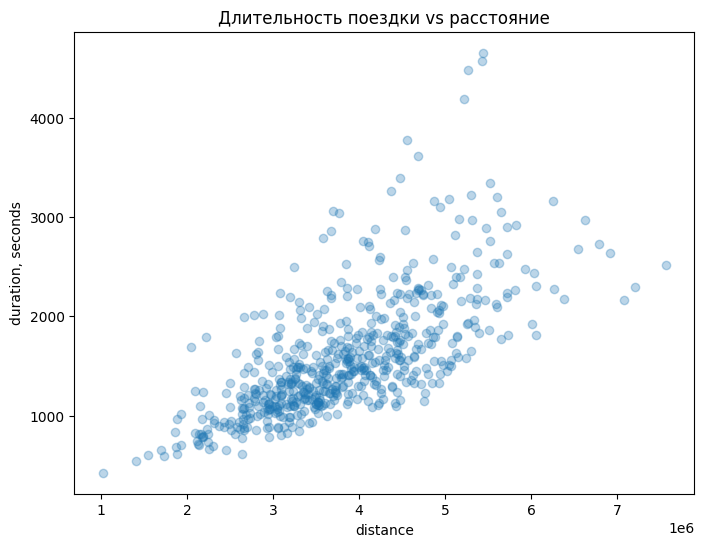

In [11]:
rides_trim_max = df_rides[df_rides['distance'] > MAX_DISTANCE]

print(f"количество поездок с расстоянием > {MAX_DISTANCE}м: {rides_trim_max['distance'].count()}")

plt.figure(figsize=(8, 6))
plt.scatter(rides_trim_max['distance'], rides_trim_max['duration'], alpha=0.3)
plt.xlabel('distance')
plt.ylabel('duration, seconds')
plt.title('Длительность поездки vs расстояние')
plt.show()

## Анализ распределения аномалий

In [12]:
# 1. Выделим аномалии (пример с distance)
mask_anomaly = (df_rides['distance'] < MIN_DISTANCE) | (df_rides['distance'] > MAX_DISTANCE)

# Добавляем маску как колонку
df_rides['is_anomaly'] = mask_anomaly.astype(int)

print(f"Всего аномалий: {mask_anomaly.sum()} ({mask_anomaly.sum() / len(df_rides) * 100:.2f}%)")
print()

# 2. Проверка по дням недели
print("=== Распределение аномалий по дням недели ===")
df_rides['day_of_week'] = df_rides['start_date'].dt.dayofweek

# Считаем долю аномалий для каждого дня
day_stats = df_rides.groupby('day_of_week').agg(
    total=('distance', 'count'),
    anomalies=('is_anomaly', 'sum')
)
day_stats['anomaly_rate_%'] = (day_stats['anomalies'] / day_stats['total'] * 100).round(2)

# Названия дней
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
day_stats.index = day_stats.index.map(lambda x: day_names[x])

print(day_stats)
print(f"\nМакс. разница в долях: {day_stats['anomaly_rate_%'].max() - day_stats['anomaly_rate_%'].min():.2f}%")
print()

# 3. Проверка по маршрутам (топ-20)
print("=== Распределение аномалий по маршрутам (топ-20) ===")
df_rides['route'] = df_rides['start_location'] + ' → ' + df_rides['end_location']

route_stats = df_rides.groupby('route').agg(
    total=('distance', 'count'),
    anomalies=('is_anomaly', 'sum')
)
route_stats['anomaly_rate_%'] = (route_stats['anomalies'] / route_stats['total'] * 100).round(2)

# Топ-20 маршрутов по количеству поездок
top_routes = route_stats.nlargest(20, 'total')
print(top_routes)
print(f"\nСредняя доля аномалий на топ-маршрутах: {top_routes['anomaly_rate_%'].mean():.2f}%")
print()

# 4. Проверка по районам
print("=== Распределение аномалий по районам отправления ===")
district_stats = df_rides.groupby('start_district').agg(
    total=('distance', 'count'),
    anomalies=('is_anomaly', 'sum')
)
district_stats['anomaly_rate_%'] = (district_stats['anomalies'] / district_stats['total'] * 100).round(2)
district_stats = district_stats.sort_values('anomaly_rate_%', ascending=False)

print(district_stats)
print(f"\nМакс. разница в долях по районам: {district_stats['anomaly_rate_%'].max() - district_stats['anomaly_rate_%'].min():.2f}%")
print()


Всего аномалий: 3532 (3.63%)

=== Распределение аномалий по дням недели ===
             total  anomalies  anomaly_rate_%
day_of_week                                  
Пн           12581        447            3.55
Вт           11061        411            3.72
Ср           11520        409            3.55
Чт           11393        400            3.51
Пт           13927        525            3.77
Сб           17772        655            3.69
Вс           17937        685            3.82

Макс. разница в долях: 0.31%

=== Распределение аномалий по маршрутам (топ-20) ===
                         total  anomalies  anomaly_rate_%
route                                                    
Буденного → Буденного       67          3            4.48
Луговая → Спортивная        67          1            1.49
Майская → Спортивная        61          1            1.64
Спортивная → Майская        60          4            6.67
Восточная → Луговая         58          1            1.72
Ломоносова → Спортив

## Визуализация анализа

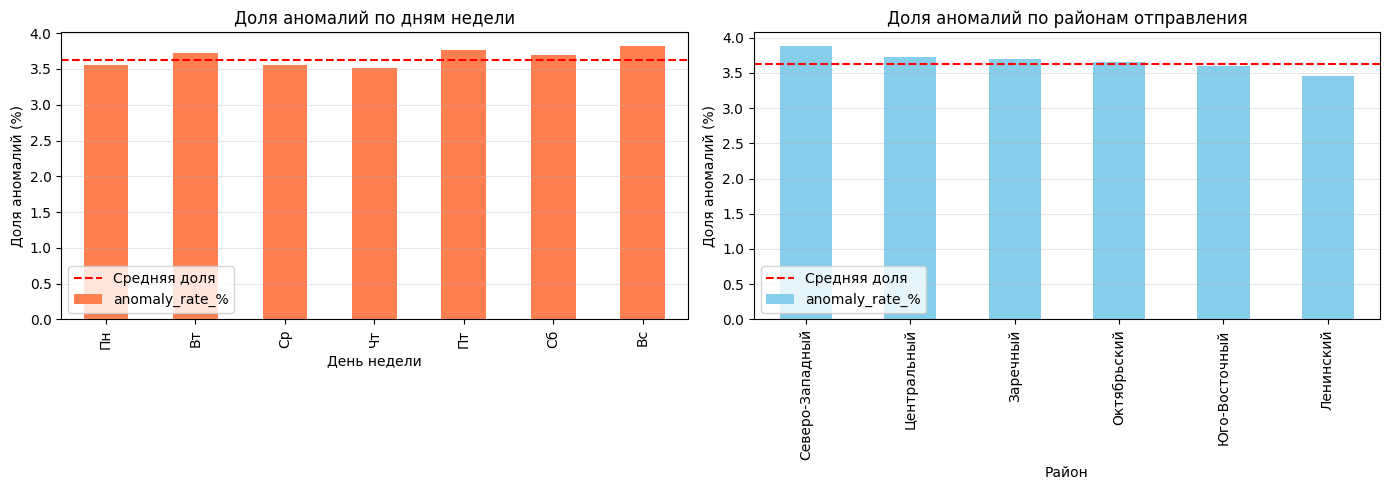

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График по дням недели
day_stats['anomaly_rate_%'].plot(kind='bar', ax=axes[0], color='coral')
axes[0].set_title('Доля аномалий по дням недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Доля аномалий (%)')
axes[0].axhline(y=mask_anomaly.sum() / len(df_rides) * 100, color='red', 
                linestyle='--', label='Средняя доля')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# График по районам
district_stats['anomaly_rate_%'].plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Доля аномалий по районам отправления')
axes[1].set_xlabel('Район')
axes[1].set_ylabel('Доля аномалий (%)')
axes[1].axhline(y=mask_anomaly.sum() / len(df_rides) * 100, color='red', 
                linestyle='--', label='Средняя доля')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Итоговая оценка равномерности

In [14]:
print("=== Итоговая оценка ===")
total_loss = mask_anomaly.sum() / len(df_rides) * 100
day_variance = day_stats['anomaly_rate_%'].std()
district_variance = district_stats['anomaly_rate_%'].std()

print(f"Общая доля потерь: {total_loss:.2f}%")
print(f"Стандартное отклонение по дням: {day_variance:.2f}%")
print(f"Стандартное отклонение по районам: {district_variance:.2f}%")

if total_loss < 5:
    print("✓ Потери < 5% - хорошо")
else:
    print("✗ Потери > 5% - много")
    
if day_variance < 1 and district_variance < 2:
    print("✓ Распределение равномерное")
else:
    print("⚠ Распределение неравномерное - возможна системная ошибка")

# Удаляем временные колонки
df_rides.drop(columns=['is_anomaly', 'day_of_week', 'route'], inplace=True)

=== Итоговая оценка ===
Общая доля потерь: 3.63%
Стандартное отклонение по дням: 0.12%
Стандартное отклонение по районам: 0.14%
✓ Потери < 5% - хорошо
✓ Распределение равномерное


## Оставим только среднюю, наибольшую часть

In [15]:
#1. Сгрупирровать поездки по точке1-точке2 причем и в обратную сторону
def filter(group):
    mask_zero_negative_distance = group['distance'] <= 0
    mask_too_short_distance = group['distance'] < MIN_DISTANCE       # менее 10 метров
    mask_too_long_distance = group['distance'] > MAX_DISTANCE        # более 60 км потому, что ограничение заряда батареи
    mask_nan_distance = (group['distance'].isna()) & (group['duration'].notna())

    if (mask_zero_negative_distance | mask_too_short_distance | mask_too_long_distance | mask_nan_distance).sum() == 0:
        return group
    
    distance_anomalies_mask = (
         mask_zero_negative_distance |
         mask_too_short_distance |
         mask_too_long_distance |
         mask_nan_distance
    )

    # берем корректные поездки
    correct_rides = group[~distance_anomalies_mask].copy()
    # берем медианную скорость по группе
    median_speed = (correct_rides['distance'] / correct_rides['duration']).median()

    # замена коротких и длинных дистанций, на медианную скорость умноженную на длительность
    group.loc[distance_anomalies_mask, 'distance'] = median_speed * group.loc[distance_anomalies_mask]['duration']
    
    return group

df_rides['group_key'] = df_rides.apply(
    lambda x: frozenset([x['start_location'], x['end_location']]), 
    axis=1
)
df_rides = df_rides.groupby('group_key', group_keys=False).apply(filter)


# Удаляем где дистанция и длительность NAN, не понятно как восстанавливать (их остается 18 штук)
df_rides = df_rides[~((df_rides['distance'].isna()) & (df_rides['duration'].isna()))]
print("Количество строк где дистанция и время Nan:", ((df_rides['distance'].isna()) & (df_rides['duration'].isna()) & (df_rides['start_date'].isna() | df_rides['end_date'].isna())).sum())

# # 1. Аномалии по жестким границам
mask_zero_negative_distance = df_rides['distance'] <= 0
mask_too_short_distance = df_rides['distance'] < MIN_DISTANCE       # менее 10 метров
mask_too_long_distance = df_rides['distance'] > MAX_DISTANCE   # более 60 км потомучто ограничение заряда батареи
mask_nan_distance = (df_rides['distance'].isna()) & (df_rides['duration'].notna())
print("Количество аномалий негативной дистанции:", mask_zero_negative_distance.sum())
print("Количество аномалий короткие дистанции:", mask_too_short_distance.sum())
print("Количество аномалий длинные дистанции:", mask_too_long_distance.sum())
print("Количество аномалий Nan:", mask_nan_distance.sum())


Количество строк где дистанция и время Nan: 0
Количество аномалий негативной дистанции: 0
Количество аномалий короткие дистанции: 0
Количество аномалий длинные дистанции: 0
Количество аномалий Nan: 0


C:\Users\TED\AppData\Local\Temp\ipykernel_30536\770358695.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rides = df_rides.groupby('group_key', group_keys=False).apply(filter)


## Восстановление данных длительности поездки от медианной скорости

In [16]:
#1. убираем проблемы с длительностью и концом поездки по группам
def filter(group):
    mask = (group['duration'].isna())

    if mask.sum() == 0:
        return group

    correct_rides = group[~mask]

    # берем медианную скорость по группе
    median_speed = (correct_rides['distance'] / correct_rides['duration']).median()

    group.loc[mask, 'duration'] = group[mask]['distance'] / median_speed
    
    #если была восстановлена длительность, восстанавливаем конец поездки
    group.loc[mask, 'end_date'] = pd.to_datetime(group[mask]['start_date'] + pd.to_timedelta(group[mask]['duration'], unit='s'))

    return group

df_rides = df_rides.groupby('group_key', group_keys=False).apply(filter)

df_rides = df_rides.drop('group_key', axis=1)  # Удаляем временный столбец

# проверка корректности
mask = (df_rides['duration'].isna())
print("Длительность Nan:", mask.sum())


Длительность Nan: 0


C:\Users\TED\AppData\Local\Temp\ipykernel_30536\3306101756.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rides = df_rides.groupby('group_key', group_keys=False).apply(filter)


## Подсчет и удаление всех NaN / NaT

In [17]:

# Сколько пропусков всего в датафрейме
total_nans = df_rides.isna().sum().sum()
print(f'Всего пропусков (NaN/NaT): {total_nans}')

# Сколько пропусков по каждому столбцу
print('Пропуски по столбцам:')
print(df_rides.isna().sum())

# Удаляем все строки с любыми пропусками
df_rides = df_rides.dropna().copy()

print(f'Размер после удаления пропусков: {df_rides.shape}')


Всего пропусков (NaN/NaT): 0
Пропуски по столбцам:
id                0
start_date        0
end_date          0
start_location    0
start_district    0
end_location      0
end_district      0
distance          0
promo             0
duration          0
dtype: int64
Размер после удаления пропусков: (97354, 10)


# Проверка промокодов

In [18]:
# промокоды должны быть только по понедельникам 6-10
mask_promo_correct = (
    (df_rides['promo'] == 1) & 
    (df_rides['start_date'].dt.dayofweek == 0) &
    (df_rides['start_date'].dt.hour >= 6) &
    (df_rides['start_date'].dt.hour < 10)
)
print(f"Корректных промо: {mask_promo_correct.sum()}")
print(f"Всего промо: {(df_rides['promo'] == 1).sum()}")


Корректных промо: 1911
Всего промо: 1911


# Финальная очистка и сохранение

In [19]:
# Сохранение результата
df_rides.to_csv('data/processing_rides.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')
print("Файл processing_rides.csv успешно сохранен.")

Файл processing_rides.csv успешно сохранен.


## Финальные даннные

In [20]:
df_rides.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0,1422.0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.0,0,1705.0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.0,0,2299.0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0,1909.0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0,1840.0
